<a href="https://colab.research.google.com/github/Alitariq747/iphone_15_causal_impact/blob/main/Iphone_15_Google_causal_impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Dates

In [ ]:
#Libraries
!pip install yfinance
!pip install tfcausalimpact

In [41]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from causalimpact import CausalImpact

The launch date of new iphone 15 is 22nd September 2023

In [42]:
#Dates
training_start = "2023-01-03"
training_end = "2023-09-21"
treatment_start = "2023-09-22"
treatment_end = "2023-11-15"
end_stock = "2023-11-16"

# Loading Financial Data

In [44]:
y = ['AAPL']
y = yf.download(tickers = y, start = training_start, end = end_stock, interval = '1d' )
y = y['Adj Close'].rename('y')
y.tail()

[*********************100%%**********************]  1 of 1 completed


Date
2023-11-09    182.169998
2023-11-10    186.399994
2023-11-13    184.800003
2023-11-14    187.440002
2023-11-15    188.009995
Name: y, dtype: float64

In [45]:
#Lets get stock prices of other companies.
stocks = ["MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "INTC", "QCOM"]
X = yf.download(tickers = stocks, start = training_start, end = end_stock, interval = '1d')
X = X['Adj Close']
X.head()


[*********************100%%**********************]  7 of 7 completed


,AMZN,GOOGL,INTC,MSFT,NVDA,QCOM,TSLA
Date,,,,,,,
2023-01-03,85.820000,89.120003,26.120346,237.474350,143.099075,105.070335,108.099998
2023-01-04,85.139999,88.080002,27.048679,227.086456,147.437561,109.314316,113.639999
2023-01-05,83.120003,86.199997,26.931416,220.356110,142.599274,107.226631,110.339996
2023-01-06,86.080002,87.339996,28.074732,222.953094,148.537155,113.048622,113.059998
2023-01-09,87.360001,88.019997,28.641500,225.123840,156.224411,112.333130,119.769997


# Data Preparation

In [46]:
#Lets care of time zones
X.index = X.index.tz_localize(None)

In [47]:
#Lets concat y and X
df = pd.concat([y, X], axis = 1).dropna()
df.head(2)


,y,AMZN,GOOGL,INTC,MSFT,NVDA,QCOM,TSLA
Date,,,,,,,,
2023-01-03,124.374809,85.820000,89.120003,26.120346,237.474350,143.099075,105.070335,108.099998
2023-01-04,125.657639,85.139999,88.080002,27.048679,227.086456,147.437561,109.314316,113.639999


In [48]:
# Prepare training dataframe
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,AMZN,GOOGL,INTC,MSFT,NVDA,QCOM,TSLA
Date,,,,,,,,
2023-09-21,173.701157,129.330002,130.440002,34.536438,318.882782,410.170013,107.959999,255.699997


In [49]:
#Check for stationarity in our y var
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]
print(test)

0.09243760385030614


Here we see that out time series for Apple stock is not stationary so we make it stationary for our analysis using difference in difference technique.

In [50]:
differencing = df_training.pct_change().dropna()
differencing.head()

,y,AMZN,GOOGL,INTC,MSFT,NVDA,QCOM,TSLA
Date,,,,,,,,
2023-01-04,0.010314,-0.007924,-0.011670,0.035541,-0.043743,0.030318,0.040392,0.051249
2023-01-05,-0.010605,-0.023726,-0.021344,-0.004335,-0.029638,-0.032816,-0.019098,-0.029039
2023-01-06,0.036794,0.035611,0.013225,0.042453,0.011785,0.041640,0.054296,0.024651
2023-01-09,0.004089,0.014870,0.007786,0.020188,0.009736,0.051753,-0.006329,0.059349
2023-01-10,0.004456,0.028732,0.004544,0.004435,0.007617,0.017981,0.020068,-0.007681


In [34]:
#Now lets again check for stationarity
test = adfuller(x = differencing.y)[1]
print(test)

3.8087048748190536e-23


<Axes: >

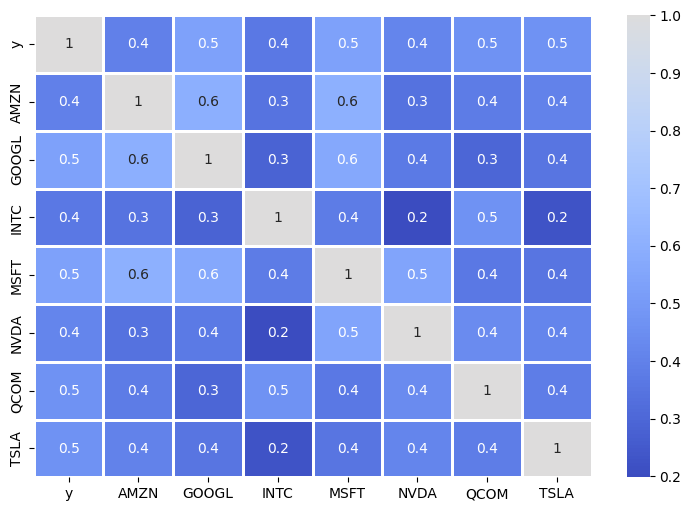

In [51]:
#Correlation check
plt.figure(figsize = (9,6))
sns.heatmap(differencing.corr(), annot = True, cmap = 'coolwarm', linewidths = 1, linecolor = 'white', fmt = '0.1g', center = True)

# Causal Impact

In [52]:
#pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

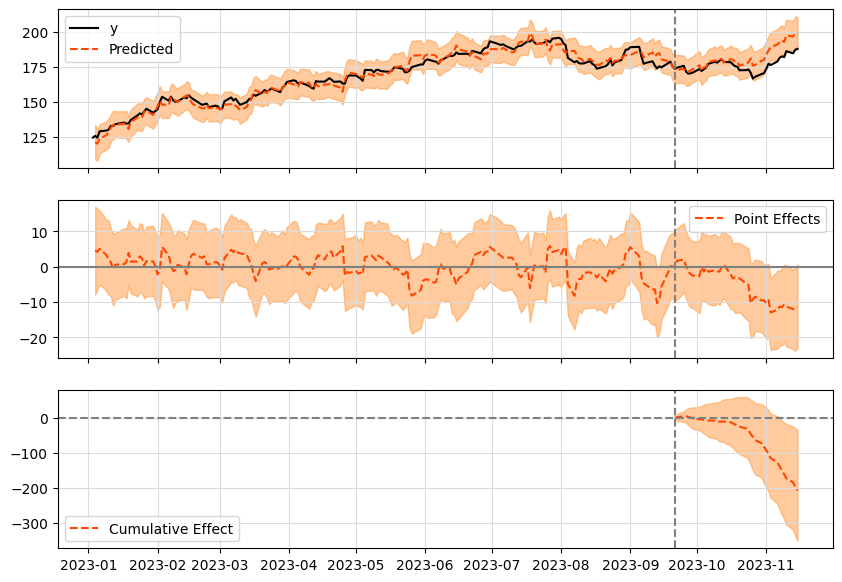

In [53]:
#Google Causal Impact
impact = CausalImpact(data = df, pre_period= pre_period, post_period= post_period)
impact.plot()

In [54]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    176.18             6870.99
Prediction (s.d.)         181.5 (2.12)       7078.41 (82.65)
95% CI                    [177.22, 185.53]   [6911.77, 7235.77]

Absolute effect (s.d.)    -5.32 (2.12)       -207.42 (82.65)
95% CI                    [-9.35, -1.05]     [-364.78, -40.78]

Relative effect (s.d.)    -2.93% (1.17%)     -2.93% (1.17%)
95% CI                    [-5.15%, -0.58%]   [-5.15%, -0.58%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.0%

For more details run the command: print(impact.summary('report'))


In [55]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 176.18. By contrast, in the absence of an
intervention, we would have expected an average response of 181.5.
The 95% interval of this counterfactual prediction is [177.22, 185.53].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -5.32 with a 95% interval of
[-9.35, -1.05]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 6870.99.
By contrast, had the intervention not taken place, we would have expected
a sum of 7078.41. The 95% interval of this prediction is [6911.77, 7235.77].


The above results are given in terms of absolute numbers. In relative
terms, the response